## Load the images
The images are loaded from the `captured_images` directory.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import ipywidgets as widgets
import PIL
import os
import glob
import cv2
from tqdm import tqdm

plt.rcParams['animation.embed_limit'] = 200 # Set the maximum size of a video to 200 MB
np.set_printoptions(suppress=True) # no scientific notation (e.g. 3.4e-3)

%matplotlib inline
image_directory = '../captured_images'

All folders with images in `captured_images`. Choose the folder you want to use and enter the index in the next cell. The descriptions are imported from `description_per_folder.txt`

In [3]:
image_folders = os.listdir(image_directory)
image_folders = [f for f in image_folders if not f.startswith('description')]
with open('../captured_images/description_per_folder.txt') as f:
    lines = f.readlines()
    
print("List of all the folders inside captured_images with a description from .description_per_folder.txt:\n")
print(" Index | Folder")
print("-------------------------------")
for idx, image_folder in enumerate(image_folders):
    print(f"   {idx}" + " " * (4 - len(str(idx))) + f"| {image_folder}")
    image_folder += '\n'
    if image_folder in lines:
        index = lines.index(image_folder)
        description = lines[index + 1]
        print("       | " +description.replace('\n', '').replace('.', '.\n       |'))


List of all the folders inside captured_images with a description from .description_per_folder.txt:

 Index | Folder
-------------------------------
   0   | 20230301-163805
       | Images captured in the Cyberzoo during the practical session on 1 March.
       | The orange pixels are converted to white pixels.
       |
   1   | 20190121-142935
       | Images from the dataset from Brightspace.
       | Cyberzoo with orange poles, a partly orange panel and floor mats.
       |
   2   | 20190121-140205
       | Images from the dataset from Brightspace.
       | Cyberzoo with orange poles and a partly orange panel.
       |
   3   | 20190121-135009
       | Images from the dataset from Brightspace.
       | Cyberzoo with orange poles.
       |


In [4]:
index_of_the_folder_you_want_to_use = 1

In [5]:
selected_folder = os.path.join(image_directory, image_folders[index_of_the_folder_you_want_to_use])
images = []
for filename in sorted(os.listdir(selected_folder)):
    file_location = os.path.join(selected_folder, filename)
    im = np.asarray(PIL.Image.open(file_location).rotate(90, expand = 1))
    images.append(im)


Some images from the folder...


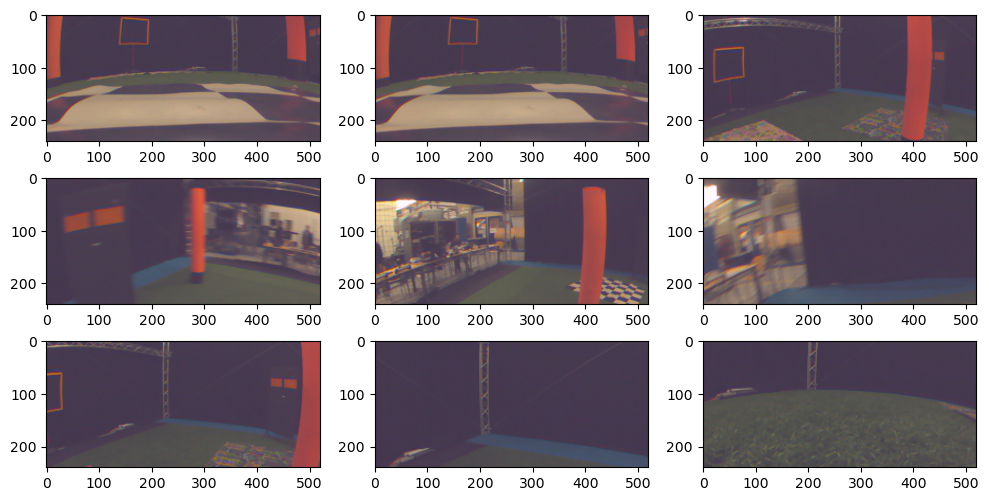

In [6]:
fig, ax = plt.subplots(3, 3)
fig.set_size_inches(12, 6)
factor = len(images) // 8
indeces = np.array([factor * i for i in range(8)] + [-1]).reshape(3,3)

print("Some images from the folder...")
for i, row in enumerate(ax):
    for j, col in enumerate(row):
        col.imshow(images[indeces[i, j]])

#### This function can be used to test your algorithm. It applies the algorithm to every images in the list of images you provide.

In [6]:
def test_algorithm(images, algorithm, **kwargs):
    converted_images = []
    for image in images:
        converted_images.append(algorithm(image, **kwargs))
        
    return converted_images

In [7]:
def create_video(images, fps=6):
    """ Really slow for a few hunderd of images """
    fig, ax = plt.subplots()
    anim_ims = []
    for image in images:
        im = ax.imshow(image, animated=True)
        anim_ims.append([im])
    ani = animation.ArtistAnimation(fig, anim_ims, interval=int(1000/fps), blit=True,
                                    repeat_delay=1000)
    plt.close()
    return HTML(ani.to_jshtml())

In [8]:
def create_widget_slider(images):
    """ Almost instantaneously produced"""
    @widgets.interact(index=(0, len(images)-1))
    def f(index=0):
        plt.imshow(images[index])

## Example of a implemented algorithm and how to use the functions

`test_algorithm(images: np.ndarray, example_function: Callable[[np.ndarray] np.ndarray]) -> np.ndarray` takes the images array and the algorithm as input and returns the images with the algorithm applied to every images. It is just a simple for loop.

`create_video(images: np.ndarray, fps=6)` displays a video of all the images. WARNING: this takes some time to load for a few hunderd images. However, when it is loaded it works.

`create_widget_slider(images: np.ndarray)` returns a jupyter widget where the images can be chosen with a slider. Works more or less instantaneously.


In [9]:
# An example algorithm
def example_algorithm(image):
    # Inverted RGB
    return image[:, :, ::-1]

images_rgb_inverted = test_algorithm(images, example_algorithm)

In [10]:
# Show a video
# create_video(images_rgb_inverted)

In [11]:
# Create a jupyter widget
# create_widget_slider(images_rgb_inverted)

## Try out -- Orange pole finder
Monday 06 March

In [12]:
create_widget_slider(images)
# Around 85 and 375 has nice orange poles

interactive(children=(IntSlider(value=0, description='index', max=471), Output()), _dom_classes=('widget-inter…

In [13]:
# create_video(images)

In [14]:
def convert_to_YUV(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2YUV)


images_YUV = test_algorithm(images, convert_to_YUV)



In [15]:
# image = images_YUV[85]

# titles = ['Y', 'U', 'V']
# fig, ax = plt.subplots(1,3, figsize=(15,5))
# for i in range(3):
#     ax[i].imshow(image[:, :, i])
#     ax[i].set_title(f"Channel {titles[i]}")
    
# filtered = np.zeros((image.shape[:2]))
# for i in range(image.shape[0]):
#     for j in range(image.shape[1]):
#         filtered[i, j] = 0 if image[i, j, 1] < 150 else 1

# plt.figure()        
# plt.imshow(filtered)
# image[:, :, 1].min()

def filter_orange(image):
    filtered = np.zeros((image.shape[:2]))
    condition = (image[:,:,1] >= 150)
    filtered[condition] = 1
        
    return filtered

In [16]:
images_orange = test_algorithm(images_YUV, filter_orange)

In [17]:
def integral_image(image):
    return np.cumsum(np.cumsum(image, axis=0), axis = 1)

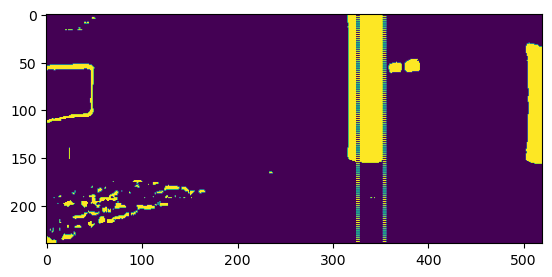

In [18]:
image = images_orange[85]
im_integral = integral_image(image)
steps = np.linspace(0, im_integral.shape[1] - 1, 20, dtype=int)
area = steps[1] * im_integral.shape[0]

pairs = []
for i, j in zip(steps[:-1], steps[1:]):
    average = (im_integral[-1, j] - im_integral[-1, i]) / area
    if average > 0.5:
        pairs.append((i, j))

for pair in pairs:
    i, j = pair
    image[::2, i - 2 : i + 2] = 1
    image[::2, j - 2 : j + 2] = 1
    image[1::2, i - 2 : i + 2] = 0
    image[1::2, j - 2 : j + 2] = 0


plt.imshow(image)

def orange_pole_finder(image):
    image_or = filter_orange(image)
    image_or_int = integral_image(image_or)
    steps = np.linspace(0, image_or_int.shape[1] - 1, 20, dtype=int)
    area = steps[1] * image_or_int.shape[0]
    
    pairs = []
    for i, j in zip(steps[:-1], steps[1:]):
        average = (image_or_int[-1, j] - image_or_int[-1, i]) / area
        if average > 0.5:
            pairs.append((i, j))

    for pair in pairs:
        i, j = pair
        image_or[::2, i - 2 : i + 2] = 1
        image_or[::2, j - 2 : j + 2] = 1
        image_or[1::2, i - 2 : i + 2] = 0
        image_or[1::2, j - 2 : j + 2] = 0
    
    return image_or
    

In [19]:
images_orange_poles = test_algorithm(images_YUV, orange_pole_finder)

In [20]:
create_widget_slider(images_orange_poles)

interactive(children=(IntSlider(value=0, description='index', max=471), Output()), _dom_classes=('widget-inter…

In [21]:
# create_video(images_orange_poles)

## Try out -- Haar features
06 March

In [22]:
def feature1(int_image, i, j, feature_size):
    """
    haar feature shape = [-1, 1]
    image: the integral image
    i, j: coordinates of the upper left corner of the position to apply the feature
    """
    fi, fj = feature_size
    assert fj % 2 == 0, "Horizontal size should be even"
    fj_half = fj // 2
    A = int_image[i, j]
    B = int_image[i + fi, j]
    C = int_image[i, j + fj_half]
    D = int_image[i + fi, j + fj_half]
    E = int_image[i, j + fj]
    F = int_image[i + fi, j + fj]

    return -A + B + 2 * C - 2 * D - E + F


def feature2(int_image, i, j, feature_size):
    """
    haar feature shape = [1, -1]
    image: the integral image
    i, j: coordinates of the upper left corner of the position to apply the feature
    """
    return -feature1(int_image, i, j, feature_size)


def feature3(int_image, i, j, feature_size):
    """
    haar feature shape = [-1,
                           1]
    image: the integral image
    i, j: coordinates of the upper left corner of the position to apply the feature
    """
    fi, fj = feature_size
    assert fi % 2 == 0, "Vertical size should be even"
    fi_half = fi // 2
    A = int_image[i, j]
    B = int_image[i, j + fj]
    C = int_image[i + fi_half, j]
    D = int_image[i + fi_half, j + fj]
    E = int_image[i + fi, j]
    F = int_image[i + fi, j + fj]

    return -A + B + 2 * C - 2 * D - E + F

def feature4(int_image, i, j, feature_size):
    """
    haar feature shape = [ 1,
                          -1]
    image: the integral image
    i, j: coordinates of the upper left corner of the position to apply the feature
    """
    return -feature3(int_image, i, j, feature_size)

def haar_feature_apply(
    image,
    haar_feature,
    i_range=[60, 180],
    j_range=[0, 520],
    i_step_size=10,
    j_step_size=10,
    feature_size=[50, 70],
    visualise=False,
):
    i_steps = (i_range[1] - i_range[0] - feature_size[0] - 1) // i_step_size + 1
    j_steps = (j_range[1] - j_range[0] - feature_size[1] - 1) // j_step_size + 1

    i_iterator = np.arange(i_steps) * i_step_size + i_range[0]
    j_iterator = np.arange(j_steps) * j_step_size + j_range[0]

    if visualise:
        fi, fj = feature_size
        image = cv2.rectangle(
            image, (j_range[0], i_range[0]), (j_range[1], i_range[1]), [255, 0, 0], 2
        )
        for i in i_iterator[:1]:
            for j in j_iterator[:1]:
                image = cv2.rectangle(image, (j, i), (j + fj, i + fi), [0, 0, 255], 2)

    # integral image
    int_image = integral_image(image)
    if len(image.shape) == 3:
        int_image = np.average(int_image, axis=2)

    # apply_filter
    feature_output = np.zeros((i_steps, j_steps))
    for idx_i, i in enumerate(i_iterator):
        for idx_j, j in enumerate(j_iterator):
            feature_output[idx_i, idx_j] = haar_feature(int_image, i, j, feature_size)

    # Convert to a range of [0, 255]
    value_range = feature_output.max() - feature_output.min()
    feature_output = (
        (feature_output - feature_output.min()) / value_range * 255
    ).astype(int)

    feature_out_long = np.repeat(np.repeat(feature_output, 12, axis=1), 12, axis=0)[
        :, : image.shape[1]
    ]

    cmap = plt.get_cmap("viridis")
    rgba_img = (cmap(feature_out_long) * 255).astype(int)
    feature_out_long_rgb = np.delete(rgba_img, 3, 2)

    if len(image.shape) == 2:
        rgba_img = (cmap(image) * 255).astype(int)
        image = np.delete(rgba_img, 3, 2)
    
    white_line = (np.ones((10, image.shape[1], 3)) * 255).astype(int)

    image_combined = np.vstack((image, white_line, feature_out_long_rgb))

    return image_combined

In [23]:
images_feature1 = test_algorithm(images, haar_feature_apply, **{'haar_feature': feature1})

In [24]:
images_feature1[0].shape

(334, 520, 3)

In [25]:
create_widget_slider(images_feature1)

interactive(children=(IntSlider(value=0, description='index', max=471), Output()), _dom_classes=('widget-inter…

In [26]:
# create_video(images_feature1)

In [27]:
images_YUV = np.array(images_YUV)
images_feature1_Y = test_algorithm(images_YUV[:,:,:,0], haar_feature_apply, **{'haar_feature': feature1})
images_feature1_U = test_algorithm(images_YUV[:,:,:,1], haar_feature_apply, **{'haar_feature': feature1})
images_feature1_V = test_algorithm(images_YUV[:,:,:,2], haar_feature_apply, **{'haar_feature': feature1})

/tmp/ipykernel_38230/3320637305.py:17: RuntimeWarning: overflow encountered in ulong_scalars
  return -A + B + 2 * C - 2 * D - E + F


In [28]:
# create_video(images_feature1_Y)

In [29]:
# create_video(images_feature1_U)

In [30]:
# create_video(images_feature1_V)

/tmp/ipykernel_38230/3320637305.py:17: RuntimeWarning: overflow encountered in ulong_scalars
  return -A + B + 2 * C - 2 * D - E + F
/tmp/ipykernel_38230/3320637305.py:46: RuntimeWarning: overflow encountered in ulong_scalars
  return -A + B + 2 * C - 2 * D - E + F


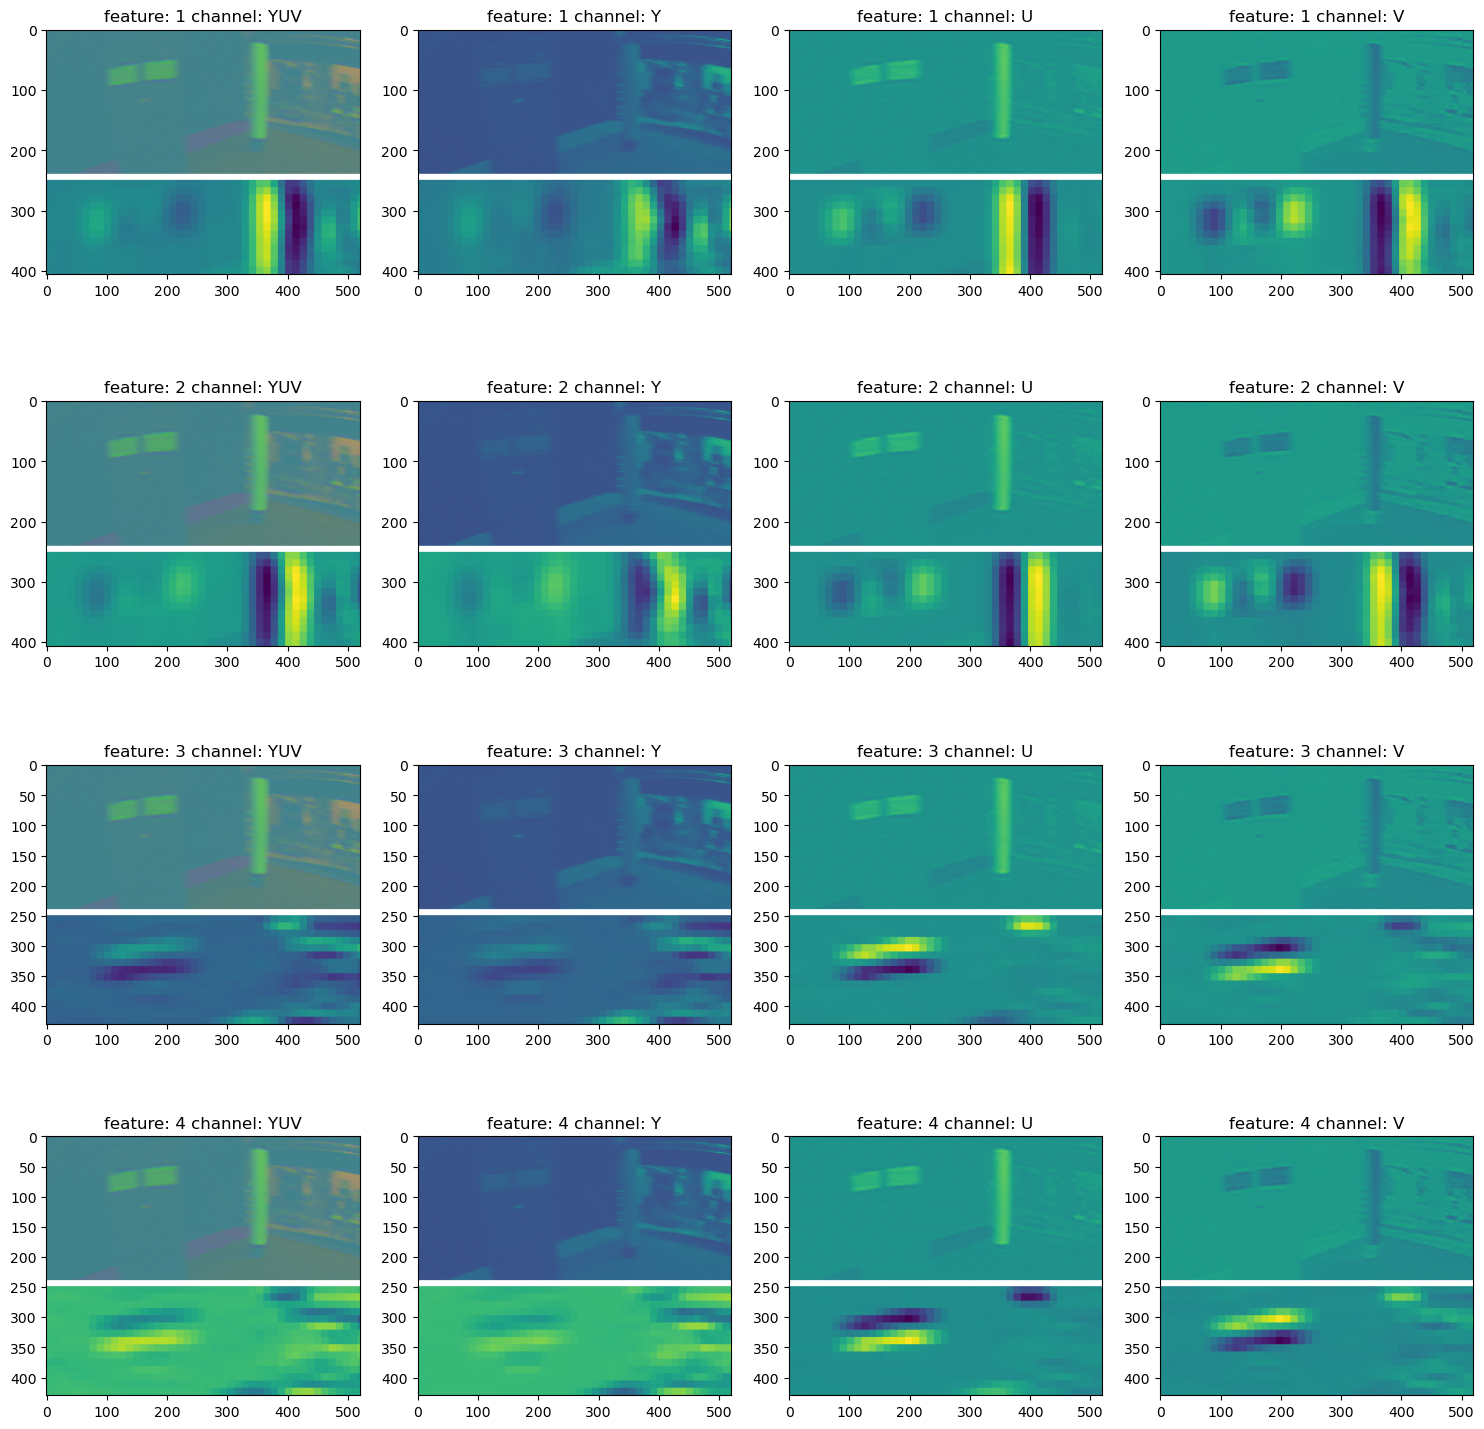

In [31]:
feature_size_vertical = [30, 50]
i_range = [0, 180]
image_panel = images_YUV[176]
images_panel = []
images_panel.append(haar_feature_apply(image_panel, feature1, i_range=i_range))
images_panel.append(haar_feature_apply(image_panel[:,:,0], feature1, i_range=i_range))
images_panel.append(haar_feature_apply(image_panel[:,:,1], feature1, i_range=i_range))
images_panel.append(haar_feature_apply(image_panel[:,:,2], feature1, i_range=i_range))
images_panel.append(haar_feature_apply(image_panel, feature2, i_range=i_range))
images_panel.append(haar_feature_apply(image_panel[:,:,0], feature2, i_range=i_range))
images_panel.append(haar_feature_apply(image_panel[:,:,1], feature2, i_range=i_range))
images_panel.append(haar_feature_apply(image_panel[:,:,2], feature2, i_range=i_range))
images_panel.append(haar_feature_apply(image_panel, feature3, i_range=i_range, feature_size=feature_size_vertical))
images_panel.append(haar_feature_apply(image_panel[:,:,0], feature3, i_range=i_range, feature_size=feature_size_vertical))
images_panel.append(haar_feature_apply(image_panel[:,:,1], feature3, i_range=i_range, feature_size=feature_size_vertical))
images_panel.append(haar_feature_apply(image_panel[:,:,2], feature3, i_range=i_range, feature_size=feature_size_vertical))
images_panel.append(haar_feature_apply(image_panel, feature4, i_range=i_range, feature_size=feature_size_vertical))
images_panel.append(haar_feature_apply(image_panel[:,:,0], feature4, i_range=i_range, feature_size=feature_size_vertical))
images_panel.append(haar_feature_apply(image_panel[:,:,1], feature4, i_range=i_range, feature_size=feature_size_vertical))
images_panel.append(haar_feature_apply(image_panel[:,:,2], feature4, i_range=i_range, feature_size=feature_size_vertical))

fig, ax = plt.subplots(4, 4, figsize=(15,15))
plt.tight_layout()

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        col.set_title(f"feature: {i+1} channel: {['YUV', 'Y', 'U', 'V'][j]}")
        col.imshow(images_panel[4*i + j])

**Conclusion Haar features**
- Do not normalise the values. Otherwise, a black wall will become completely yellow (max value)
- U-value can be used to detect orange. Even against the bright table with people.

**Ideas**
- Try out bigger, heigher, wider feature.

In [45]:
images[0].shape

(240, 520, 3)

In [51]:
images_subtract = []
for im1, im2 in zip(images[:-1], images[1:]):
    subtract_im = np.average(im1-im2, axis=2)
    subtract_im = cv2.resize(subtract_im, dsize=(52,24))
    subtract_im[subtract_im < 200] = 0
    subtract_im[subtract_im > 1] = 1
    images_subtract.append(subtract_im)
    

In [52]:
create_widget_slider(images_subtract)

interactive(children=(IntSlider(value=0, description='index', max=470), Output()), _dom_classes=('widget-inter…

In [18]:
# Save a mp4 video
step = 1
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter('test.mp4', fourcc, 6.0, (520//step,240//step))
for image in images:
    out.write(image[::step,::step,::1])
    
out.release()

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


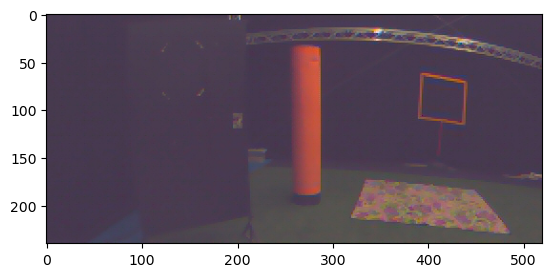

In [21]:
plt.imshow(images[310])

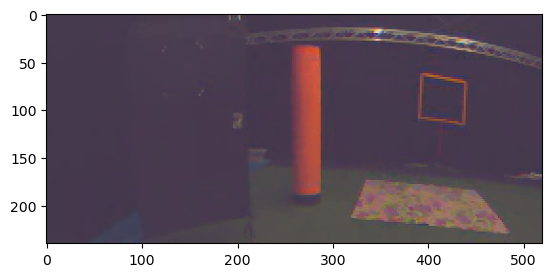

In [19]:
from numpy.lib.type_check import imag

minimum = 4000                  #Define Min Contour area
frame1 = None
cap = cv2.VideoCapture('test.mp4')   # Capture object to access the camera

not_finished = True
i = 0
knn = cv2.createBackgroundSubtractorKNN() 

while not_finished:
    not_finished, frame = cap.read()
    
    if i == 310:
        plt.imshow(frame)

    i+=1

# bgs = knn.apply(vid)


In [1]:
# BGS based tracking 

import numpy as np
import matplotlib.pyplot as plt
import cv2
from numpy.lib.type_check import imag

minimum = 4000                  #Define Min Contour area
frame1 = None
cap = cv2.VideoCapture('test.mp4')   # Capture object to access the camera
method = 'KNN'

# Background Subtraction Methods
mog = cv2.createBackgroundSubtractorMOG2()  
knn = cv2.createBackgroundSubtractorKNN()   

while True:
    ret, frame = cap.read()
    vid = cv2.flip(frame,1)
    
    if method == 'MOG2':
        bgs = mog.apply(vid)
        
    
    elif method == 'KNN':
        bgs = knn.apply(vid)
# Using Frame difference method to find the change in the scene. Current frame 
# is subtracted from the first frame which is assumed to be static and contains no 
# Foreground object.
    
    elif method == 'ABS':
        frame = cv2.GaussianBlur(vid,(7,7),0)
        frame = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
        
        if frame1 is None:
            frame1 = frame
            continue 
        
        framedelta = cv2.absdiff(frame1,frame)
        retval, bgs = cv2.threshold(framedelta.copy(), 50, 255, cv2.THRESH_BINARY)
    
    mask = np.zeros_like(frame)

# Finding contours and Draw them of the frame
    
    contours,_ = cv2.findContours(bgs, mode= cv2.RETR_TREE, method= cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours,key=cv2.contourArea,reverse= True)

    
    for cnt in contours:
        if cv2.contourArea(cnt) < minimum:
                continue
        
        (x,y,w,h) = cv2.boundingRect(cnt)
        cv2.rectangle(vid,(x,y),(x+w,y+h),(0,255,10),1)
        cv2.putText(vid,f'{method}',(20,20),cv2.FONT_HERSHEY_COMPLEX_SMALL,1,(0,255,0,2))
        cv2.putText(vid,'Motion Detected',(20,40),cv2.FONT_HERSHEY_COMPLEX_SMALL,1,(0,255,0,2))
        #cv2.drawContours(bgs,cnt,-1,255,3)
        cv2.drawContours(mask,cnt,-1,255,3)
        break

    cv2.imshow('frame',vid)
    cv2.imshow('BGS',bgs)


    key = cv2.waitKey(1)
    if key == ord('q') or key == ord('Q'):
        break
    elif key == ord('M') or key == ord('m'):
        method = 'MOG2'
    elif key == ord('K') or key == ord('k'):
        method = 'KNN'
    elif key == ord('A') or key == ord('a'):
        method = 'ABS'

cap.release()
cv2.destroyAllWindows()

QObject::moveToThread: Current thread (0x192a5e0) is not the object's thread (0x1a654a0).
Cannot move to target thread (0x192a5e0)

QObject::moveToThread: Current thread (0x192a5e0) is not the object's thread (0x1a654a0).
Cannot move to target thread (0x192a5e0)

QObject::moveToThread: Current thread (0x192a5e0) is not the object's thread (0x1a654a0).
Cannot move to target thread (0x192a5e0)

QObject::moveToThread: Current thread (0x192a5e0) is not the object's thread (0x1a654a0).
Cannot move to target thread (0x192a5e0)

QObject::moveToThread: Current thread (0x192a5e0) is not the object's thread (0x1a654a0).
Cannot move to target thread (0x192a5e0)

QObject::moveToThread: Current thread (0x192a5e0) is not the object's thread (0x1a654a0).
Cannot move to target thread (0x192a5e0)

QObject::moveToThread: Current thread (0x192a5e0) is not the object's thread (0x1a654a0).
Cannot move to target thread (0x192a5e0)

QObject::moveToThread: Current thread (0x192a5e0) is not the object's thread

error: OpenCV(4.6.0) /io/opencv/modules/imgproc/src/smooth.dispatch.cpp:617: error: (-215:Assertion failed) !_src.empty() in function 'GaussianBlur'
